This file provides a simulator of PV loops with LVAD and without LVAD. In addition, given a set of $\omega(0)$ values (the initial rotation speed of the LVAD), the code generates the PV loops obtained for each $\omega(0)$, and plots several relevant cardiovascular properties as a function of $\omega(0)$. These properties include aortic pressure (Pao) at end-diastole (ED) and end-systole (ES), and cardiac output (CO). This information would allow to properly select an appropriate value of gamma for a given patient

In [1]:
import numpy as np
import torch
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import os
from skimage.transform import rescale, resize
import torch.nn.functional as F
from torch.utils.data import Subset

import time
from scipy.integrate import odeint #collection of advanced numerical algorithms to solve initial-value problems of ordinary differential equations.
from matplotlib import pyplot as plt
import random
import sys

def heart_ode0(y, t, Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emax, Emin, Tc):
    x1, x2, x3, x4, x5 = y #here y is a vector of 5 values (not functions), at time t, used for getting (dy/dt)(t)
    P_lv = Plv(x1,Emax,Emin,t,Tc)
    dydt = [r(x2-P_lv)/Rm-r(P_lv-x4)/Ra, (x3-x2)/(Rs*Cr)-r(x2-P_lv)/(Cr*Rm), (x2-x3)/(Rs*Cs)+x5/Cs, -x5/Ca+r(P_lv-x4)/(Ca*Ra), (x4-x3-Rc*x5)/Ls]
    return dydt

def getslope(y1, y2, y3, x1, x2, x3):
  sum_x = x1 + x2 + x3
  sum_y = y1 + y2 + y3
  sum_xy = x1*y1 + x2*y2 + x3*y3
  sum_xx = x1*x1 + x2*x2 + x3*x3
  # calculate the coefficients of the least-squares line
  n = 3
  slope = (n*sum_xy - sum_x*sum_y) / (n*sum_xx - sum_x*sum_x)
  return slope

### ODE: for each t (here fixed), gives dy/dt as a function of y(t) at that t, so can be used for integrating the vector y over time
#it is run for each t going from 0 to tmax
def heart_ode(y, t, Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emax, Emin, Tc, ratew):
    '''
    #from simaan2008dynamical:
    Ri = 0.0677
    R0 = 0.0677
    Rk = 0
    x1bar = 1.
    alpha = -3.5
    Li = 0.0127
    L0 = 0.0127
    b0 = -0.17070
    b1 = -0.02177
    b2 = 9.9025e-7
    '''
    #b0, b1 rom [22] in simaan2008dynamical:
    Ri = 0.0677
    R0 = 0.0677
    Rk = 0
    x1bar = 1.
    alpha = -3.5
    Li = 0.0127
    L0 = 0.0127
    b0 = -0.296
    b1 = -0.027
    b2 = 9.9025e-7
    '''#made up:
    Ri = 0.0677
    R0 = 0.0677
    Rk = 0
    x1bar = 1.
    alpha = -3.5
    Li = 0.0127
    L0 = 0.0127
    b0 = -0.4
    b1 = -0.03
    b2 = 9.9025e-7
    '''

    x1, x2, x3, x4, x5, x6, x7 = y #here y is a vector of 5 values (not functions), at time t, used for getting (dy/dt)(t)

    P_lv = Plv(x1,Emax,Emin,t,Tc)
    if (P_lv <= x1bar): Rk = alpha * (P_lv - x1bar)
    Lstar = Li + L0 + b1
    Lstar2 = -Li -L0 +b1
    Rstar = Ri + + R0 + Rk + b0

    dydt = [-x6 + r(x2-P_lv)/Rm-r(P_lv-x4)/Ra, (x3-x2)/(Rs*Cr)-r(x2-P_lv)/(Cr*Rm), (x2-x3)/(Rs*Cs)+x5/Cs, -x5/Ca+r(P_lv-x4)/(Ca*Ra) + x6/Ca, (x4-x3)/Ls-Rc*x5/Ls, -P_lv / Lstar2 + x4/Lstar2 + (Ri+R0+Rk-b0) / Lstar2 * x6 - b2 / Lstar2 * x7**2, ratew]

    return dydt

def r(u):
    if u<0:
        return 0
    else:
        return u

#returns Plv at time t using Elastance(t) and Vlv(t)-Vd=x1
def Plv(x1,Emax,Emin,t, Tc):
    return Elastance(Emax,Emin,t, Tc)*x1

#returns Elastance(t)
def Elastance(Emax,Emin,t, Tc):
    t = t-int(t/Tc)*Tc #can remove this if only want 1st ED (and the 1st ES before)
    tn = t/(0.2+0.15*Tc)
    return (Emax-Emin)*1.55*(tn/0.7)**1.9/((tn/0.7)**1.9+1)*1/((tn/1.17)**21.9+1) + Emin

#returns pv loop and ef when there is no lvad:
def f_nolvad(Tc, start_v, Emax, showpvloop):

    N = 20
    global Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emin, Vd

    start_pla = float(start_v*Elastance(Emax, Emin, 0, Tc))
    start_pao = 75.
    start_pa = start_pao
    start_qt = 0 #aortic flow is Q_T and is 0 at ED, also see Fig5 in simaan2008dynamical

    y0 = [start_v, start_pla, start_pa, start_pao, start_qt]

    t = np.linspace(0, Tc*N, int(60000*N)) #spaced numbers over interval (start, stop, number_of_steps), 60000 time instances for each heart cycle
    #changed to 60000 for having integer positions for Tmax
    #obtain 5D vector solution:
    sol = odeint(heart_ode0, y0, t, args = (Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emax, Emin, Tc)) #t: list of values

    result_Vlv = np.array(sol[:, 0]) + Vd
    result_Plv = np.array([Plv(v, Emax, Emin, xi, Tc) for xi,v in zip(t,sol[:, 0])])

    if showpvloop: plt.plot(result_Vlv[18*60000:20*60000], result_Plv[18*60000:20*60000], color='black', label='Without LVAD')

    ved = sol[19*60000, 0] + Vd
    ves = sol[200*int(60/Tc)+9000+19*60000, 0] + Vd
    ef = (ved-ves)/ved * 100.
    minv = min(result_Vlv[19*60000:20*60000-1])
    minp = min(result_Plv[19*60000:20*60000-1])

    result_pao = np.array(sol[:, 3])
    pao_ed = min(result_pao[(N-1)*60000:N*60000-1])
    pao_es = max(result_pao[(N-1)*60000:N*60000-1])

    return ef, pao_ed, pao_es, ((ved - ves) * 60/Tc ) / 1000, sol[19*60000, 0], sol[19*60000, 1], sol[19*60000, 2], sol[19*60000, 3], sol[19*60000, 4], result_Vlv[18*60000:20*60000], result_Plv[18*60000:20*60000]

#returns the w at which suction occurs: (i.e. for which the slope of the envelopes of x6 becomes negative)
def get_suctionw(Tc, start_v, Emax, y00, y01, y02, y03, y04, w0, x60, ratew): #slope is slope0 for w

    N = 70
    global Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emin, Vd

    start_pla = float(start_v*Elastance(Emax, Emin, 0, Tc))
    start_pao = 75.
    start_pa = start_pao
    start_qt = 0 #aortic flow is Q_T and is 0 at ED, also see Fig5 in simaan2008dynamical

    y0 = [start_v, start_pla, start_pa, start_pao, start_qt, x60, w0]
    y0 = [y00, y01, y02, y03, y04, x60, w0]

    ncycle = 20000
    n = N * ncycle
    sol = np.zeros((n, 7))
    t = np.linspace(0., Tc * N, n)
    for j in range(7):
      sol[0][j] = y0[j]

    result_Vlv = []
    result_Plv = []
    result_x6 = []
    result_x7 = []
    envx6 = []
    timesenvx6 = []
    slopes = []
    ws = []

    minx6 = 99999
    tmin = 0
    tlastupdate = 0
    lastw = w0
    update = 1

    #solve the ODE step by step by adding dydt*dt:
    for j in range(0, n-1):
      #update y with dydt * dt
      y = sol[j]
      dydt = heart_ode(y, t[j], Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emax, Emin, Tc, ratew)
      for k in range(7):
        dydt[k] = dydt[k] * (t[j+1] - t[j])
      sol[j+1] = sol[j] + dydt

      #update the min of x6 in the current cylce. also keep the time at which the min is obtained (for getting the slope later)
      if (minx6 > sol[j][5]):
        minx6 = sol[j][5]
        tmin = t[j]

      #add minimum of x6 once each cycle ends: (works). then reset minx6 to 99999 for calculating again the minimum
      if (j%ncycle==0 and j>1):
        envx6.append(minx6)
        timesenvx6.append(tmin)
        minx6 = 99999

      if (len(envx6)>=3):
        slope = getslope(envx6[-1], envx6[-2], envx6[-3], timesenvx6[-1], timesenvx6[-2], timesenvx6[-3])
        slopes.append(slope)
        ws.append(y[6])

    for i in range(n):
      result_x6.append(sol[i, 5])
      result_x7.append(sol[i, 6])

    suction_w = 0
    for i in range(2, len(slopes)):
      if (slopes[i] < 0):
        suction_w = ws[i-1]
        break

    #w(t)=w0+ratew*t=suction_w -> t=(suction_w - w0)/ratew

    #plot w(t)
    plt.title("w(t)")
    plt.ylabel('w(t) (rpm)')
    plt.xlabel('t (s)')
    plt.plot(t, result_x7)
    plt.show()

    #plot x6(t)
    plt.title("Flow through LVAD")
    plt.ylabel('x_6(t) (ml/s)')
    plt.xlabel('t (s)')
    plt.plot(t, result_x6)
    plt.axvline(x=(suction_w - w0)/ratew, color='r', linestyle='--')
    plt.show()

    return suction_w

def f_lvad(Tc, start_v, Emax, c, slope, w0, x60, y00, y01, y02, y03, y04): #slope is slope0 for w

    N = 70
    global Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emin, Vd

    y0 = [y00, y01, y02, y03, y04, x60, w0]

    ncycle = 10000
    n = N * ncycle
    sol = np.zeros((n, 7))
    t = np.linspace(0., Tc * N, n)
    for j in range(7):
      sol[0][j] = y0[j]

    result_Vlv = []
    result_Plv = []
    result_x6 = []
    result_x7 = []
    envx6 = []
    timesenvx6 = []

    minx6 = 99999
    tmin = 0
    tlastupdate = 0
    lastw = w0
    update = 1
    ratew = 0 #6000/60

    #solve the ODE step by step by adding dydt*dt:
    for j in range(0, n-1):
      #update y with dydt * dt
      y = sol[j]
      dydt = heart_ode(y, t[j], Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emax, Emin, Tc, ratew)
      for k in range(7):
        dydt[k] = dydt[k] * (t[j+1] - t[j])
      sol[j+1] = sol[j] + dydt

      #update the min of x6 in the current cylce. also keep the time at which the min is obtained (for getting the slope later)
      if (minx6 > sol[j][5]):
        minx6 = sol[j][5]
        tmin = t[j]

      #add minimum of x6 once each cycle ends: (works). then reset minx6 to 99999 for calculating again the minimum
      if (j%ncycle==0 and j>1):
        envx6.append(minx6)
        timesenvx6.append(tmin)
        minx6 = 99999

      #update w (if 0.005 s. have passed since the last update):
      if (slope<0):
        update = 0
      if (t[j+1] - tlastupdate > 0.005 and slope>0 and update==1): #abs(slope)>0.0001
        # if there are enough points of envelope: calculate slope:
        if (len(envx6)>=3):
          slope = getslope(envx6[-1], envx6[-2], envx6[-3], timesenvx6[-1], timesenvx6[-2], timesenvx6[-3])
          sol[j+1][6] = lastw + c * slope
        #otherwise: take arbitrary rate (see Fig. 16a in simaan2008dynamical)
        else:
          sol[j+1][6] = lastw + 0.005 * slope
        #save w(k) (see formula (8) simaan2008dynamical) and the last time of update t[j] (will have to wait 0.005 s for next update of w)
        tlastupdate = t[j+1]
        lastw = sol[j+1][6]

    #save functions and print MAP, CO:
    map = 0
    Pao = []

    for i in range(n):
      result_Vlv.append(sol[i, 0] + Vd)
      result_Plv.append(Plv(sol[i, 0], Emax, Emin, t[i], Tc))
      result_x6.append(sol[i, 5])
      result_x7.append(sol[i, 6])
      Pao.append(sol[i, 3])

    colors0=np.zeros((len(result_Vlv[65*ncycle:70*ncycle]), 3))
    for col in colors0:
      col[0]=41/255
      col[1]=128/255
      col[2]=205/255

    #plot pv loops:
    #plt.title("PV loops (black: no LVAD; blue: with LVAD)")
    '''
    plt.plot(result_Vlv[65*ncycle:70*ncycle], result_Plv[65*ncycle:70*ncycle], color=(41/255, 128/255, 205/255), label='With FC-LVAD')
    plt.xlabel('LV volume (ml)')
    plt.ylabel('LV pressure (mmHg)')
    plt.xlim(20,130)
    plt.legend(loc='upper left', framealpha=1)
    plt.show()
    '''

    '''
    #plot result_Plv, and aortic pressure:
    plt.title("Plv (red), Pao (blue)")
    plt.plot(t, result_Plv, color='r')
    plt.plot(t, Pao, color='b')
    plt.xlabel('t (s)')
    plt.ylabel('Pressures (mmHg)')
    plt.show()
    '''

    '''
    #plot Vlv(t):
    plt.plot(t[48*ncycle: 52*ncycle], result_Vlv[48*ncycle: 52*ncycle])
    plt.title("Vlv(t) ")
    plt.ylabel('V_LV (ml)')
    plt.xlabel('t (s)')
    plt.show()
    '''

    #get co and ef:
    ved = max(result_Vlv[50 * ncycle:52 * ncycle])
    ves = min(result_Vlv[50 * ncycle:52 * ncycle])
    #ves = result_Vlv[50 * ncycle + int(ncycle * 0.2 /Tc + 0.15 * ncycle)]
    ef = (ved-ves)/ved*100
    CO = ((ved - ves) * 60/Tc ) / 1000

    #get MAP:
    for i in range(n - 5*ncycle, n):
      map += sol[i, 2]
    map = map/(5*ncycle)

    plott=1
    if plott==0:
      #plot w(t)
      plt.title("w(t)")
      plt.ylabel('w(t) (rpm)')
      plt.xlabel('t (s)')
      plt.plot(t, result_x7)
      plt.show()

      #plot x6(t)
      plt.title("Flow through LVAD")
      plt.ylabel('x_6(t) (ml/s)')
      plt.xlabel('t (s)')
      plt.plot(t, result_x6)
      plt.show()

    result_pao = np.array(sol[:, 3])
    pao_ed = min(Pao[50 * ncycle:52 * ncycle])
    pao_es = max(Pao[50 * ncycle:52 * ncycle])

    return ef, pao_ed, pao_es, CO, map, result_Vlv[65*ncycle:70*ncycle], result_Plv[65*ncycle:70*ncycle]

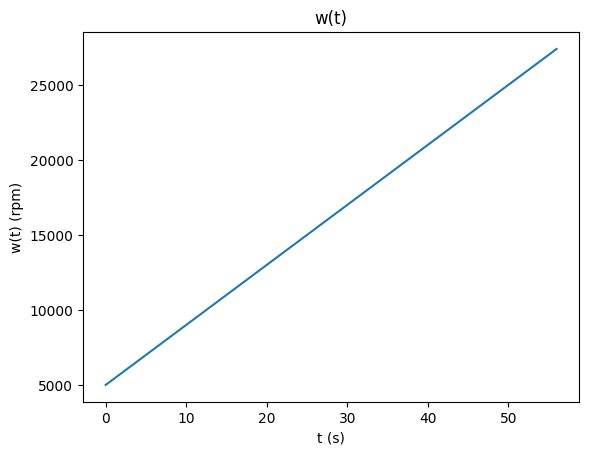

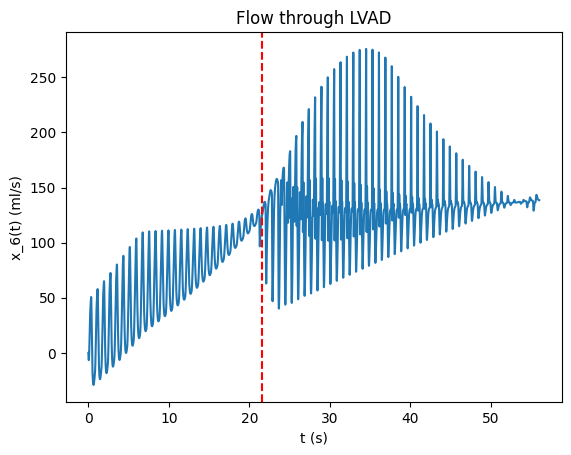


Parameters: Tc, start_v, Emax: 0.8 100.0 0.6
Suction speed: 13639.990171314741
EF before LVAD: 20.11624776373387
CO before LVAD: 2.0672094727251094
New EF after LVAD: 44.312773977628176 New CO: 1.1698008153568218 New MAP: 123.31701618239201 



Parameters: Tc, start_v, Emax: 0.8 100.0 0.6
Suction speed: 13639.990171314741
EF before LVAD: 20.11624776373387
CO before LVAD: 2.0672094727251094
New EF after LVAD: 40.62071124701709 New CO: 2.2484155468808567 New MAP: 93.41551037026558 



Parameters: Tc, start_v, Emax: 0.8 100.0 0.6
Suction speed: 13639.990171314741
EF before LVAD: 20.11624776373387
CO before LVAD: 2.0672094727251094
New EF after LVAD: 28.999252584286484 New CO: 2.1235655909138904 New MAP: 75.70150546590594 



Parameters: Tc, start_v, Emax: 0.8 100.0 0.6
Suction speed: 13639.990171314741
EF before LVAD: 20.11624776373387
CO before LVAD: 2.0672094727251094
New EF after LVAD: 23.352515879682723 New CO: 1.9838148722055764 New MAP: 64.1932374501219 



Parameters: Tc, start_v,

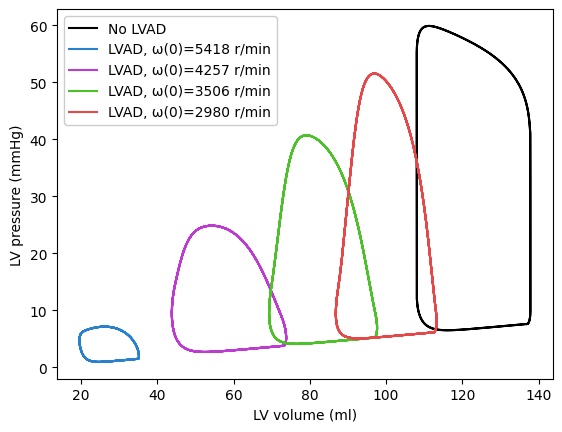

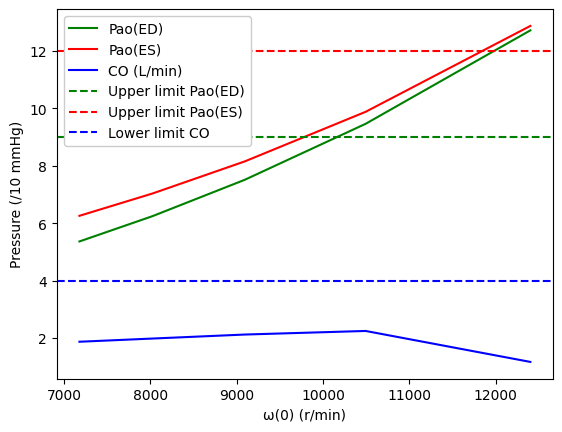

[120.2834966942318, 101.92986149359939, 44.15835858100307, 16.08783185591543, -0.015952132385266736]


'\nValues that can be arbitrarily chosen for the LVAD:\n\n- c (rate at which w is updated after about 2.5 seconds, using the envelope of x6) (0.67 in simaan2008dynamical but taken lower)\n- slope0 (initial slope of w during the first \\sim2.5s, when there are still not 3 points for calculating the slope of the envelope of x6) (around 400 in simaan2008dynamical)\n- w0 (initial value of w, in rpm) (around 12000-14000 in simaan2008dynamical)\n- x60 (initial flow in the LVAD) (around 122 in simaan2008dynamical)\n\n- internal values of the LVAD: R0, Ri, Rk (defined by x1bar, alpha), Li, L0, b0, b1, b2.\n-> Taken from simaan2008dynamical but could also take b0, b1, b2 from choi1997modeling ([22] in simaan2008dynamical)\n'

In [2]:
##patient1:

N = 70
ncycle = 10000
Tc = 0.8
start_v = 100.
Emax = 0.6
Emin = 0.06
Rm = 0.05
Ra = 0.001
Vd = 10.

Rs = 1.
Rc = 0.0398
Ca= 0.08
Cs= 1.33
Cr= 4.4
Ls=0.0005

gammas = [1.1, 1.3, 1.5, 1.7, 1.9]

vlv_fctns = []
plv_fctns = []
ef_changes = []
pao_eds = []
pao_ess = []
cos = []
maps = []

#get values for periodic loops:
ef_nolvad, pao_ed, pao_es, co_nolvad, y00, y01, y02, y03, y04, Vlv0, Plv0 = f_nolvad(Tc, start_v, Emax, 0)
#pao_eds = [pao_ed]
#pao_ess = [pao_es]

#get suction w: (make w go linearly from w0 to w0 + maxtime * 400, and find w at which suction occurs)
w0 = 5000.
ratew = 400.
x60 = 0.
suctionw = get_suctionw(Tc, start_v, Emax, y00, y01, y02, y03, y04, w0, x60, ratew)

speeds = []
for gamma in gammas: speeds.append(suctionw / gamma)
for gamma in gammas:

  #parameters for lvad:
  c = 0.065 #(in simaan2008dynamical: 0.67, but too fast -> 0.061 gives better shape)
  #with 1.9 also increases CO
  #or between 1.4-2.1 (will make the new pv loop with lvad get closer or further away from the no-lvad pv loop)
  slope0 = 100.
  w0 = suctionw / gamma  #if doesn't work (x6 negative), change gamma down to 1.4 or up to 2.1
  #x60 = 122. #from simaan2008dynamical
  x60 = 0.

  #compute new pv loops and ef with lvad added:
  new_ef, pao_ed, pao_es, CO, MAP, Vlvs, Plvs = f_lvad(Tc, start_v, Emax, c, slope0, w0, x60, y00, y01, y02, y03, y04)
  vlv_fctns.append(Vlvs)
  plv_fctns.append(Plvs)
  pao_eds.append(pao_ed)
  pao_ess.append(pao_es)
  cos.append(CO)
  maps.append(MAP)
  ef_changes.append((new_ef - ef_nolvad) / ef_nolvad * 100.)

  print("\nParameters: Tc, start_v, Emax:", Tc, start_v, Emax)
  print("Suction speed:", suctionw)
  print("EF before LVAD:", ef_nolvad)
  print("CO before LVAD:", co_nolvad)
  print("New EF after LVAD:", new_ef, "New CO:", CO, "New MAP:", MAP, "\n\n")

plt.plot(Vlv0, Plv0, color='black', label='No LVAD') #black
plt.plot(vlv_fctns[0], plv_fctns[0], color=(41/255, 128/255, 205/255), label='LVAD, ω(0)=5418 r/min') #blue
plt.plot(vlv_fctns[1], plv_fctns[1], color=(189/255, 59/255, 209/255), label='LVAD, ω(0)=4257 r/min') #pink
plt.plot(vlv_fctns[2], plv_fctns[2], color=(78/255, 192/255, 44/255), label='LVAD, ω(0)=3506 r/min') #green
plt.plot(vlv_fctns[3], plv_fctns[3], color=(228/255, 72/255, 72/255), label='LVAD, ω(0)=2980 r/min') #red
plt.xlabel('LV volume (ml)')
plt.ylabel('LV pressure (mmHg)')
plt.legend(loc='upper left', framealpha=1)
plt.show()

for i in range(len(pao_eds)):
  pao_eds[i] = pao_eds[i]/10.
  pao_ess[i] = pao_ess[i]/10.
plt.plot(speeds, pao_eds, color='green', label='Pao(ED)')
plt.plot(speeds, pao_ess, color='red', label='Pao(ES)')
plt.plot(speeds, cos, color='blue', label='CO (L/min)')
plt.axhline(y=9, color='green', linestyle='--', label='Upper limit Pao(ED)')
plt.axhline(y=12, color='red', linestyle='--', label='Upper limit Pao(ES)')
plt.axhline(y=4, color='blue', linestyle='--', label='Lower limit CO')
plt.xlabel('ω(0) (r/min)')
plt.ylabel('Pressure (/10 mmHg)')
plt.legend(loc='upper left', framealpha=1)
plt.show()

print(ef_changes)

#comment about parameters of the LVAD:

'''
Values that can be arbitrarily chosen for the LVAD:

- c (rate at which w is updated after about 2.5 seconds, using the envelope of x6) (0.67 in simaan2008dynamical but taken lower)
- slope0 (initial slope of w during the first \sim2.5s, when there are still not 3 points for calculating the slope of the envelope of x6) (around 400 in simaan2008dynamical)
- w0 (initial value of w, in rpm) (around 12000-14000 in simaan2008dynamical)
- x60 (initial flow in the LVAD) (around 122 in simaan2008dynamical)

- internal values of the LVAD: R0, Ri, Rk (defined by x1bar, alpha), Li, L0, b0, b1, b2.
-> Taken from simaan2008dynamical but could also take b0, b1, b2 from choi1997modeling ([22] in simaan2008dynamical)
'''

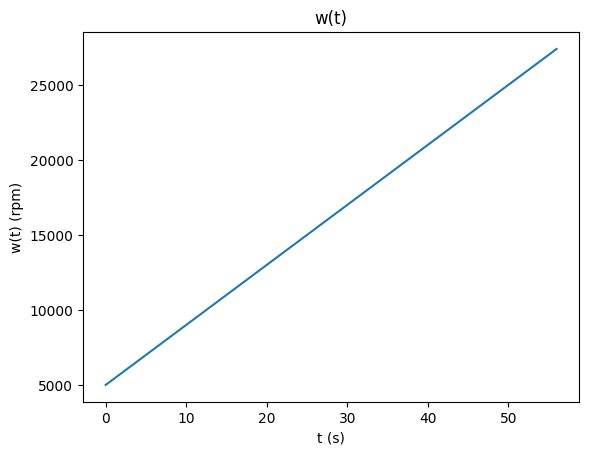

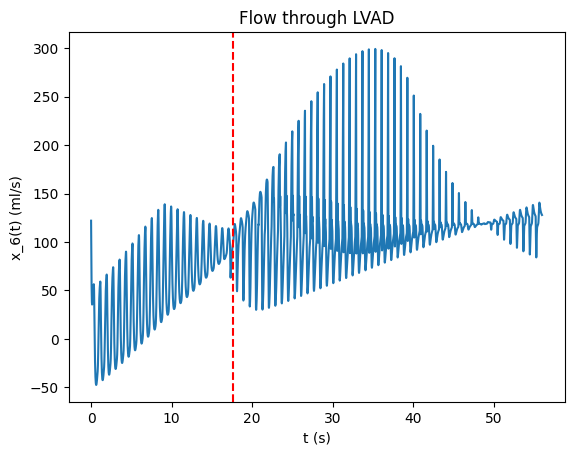


Parameters: Tc, start_v, Emax: 0.8 70.0 1.2
Suction speed: 12039.989028481534
EF before LVAD: 34.341861409347416
CO before LVAD: 2.8128869930532696
New EF after LVAD: 58.78975289394146 New CO: 2.1583112275267236 New MAP: 96.46603933534777 



Parameters: Tc, start_v, Emax: 0.8 70.0 1.2
Suction speed: 12039.989028481534
EF before LVAD: 34.341861409347416
CO before LVAD: 2.8128869930532696
New EF after LVAD: 44.61771879436584 New CO: 2.4953772903330864 New MAP: 77.84306912577935 



Parameters: Tc, start_v, Emax: 0.8 70.0 1.2
Suction speed: 12039.989028481534
EF before LVAD: 34.341861409347416
CO before LVAD: 2.8128869930532696
New EF after LVAD: 36.43568603978901 New CO: 2.5273489756840286 New MAP: 65.36018778262378 



Parameters: Tc, start_v, Emax: 0.8 70.0 1.2
Suction speed: 12039.989028481534
EF before LVAD: 34.341861409347416
CO before LVAD: 2.8128869930532696
New EF after LVAD: 39.3382829862752 New CO: 3.0096103464743833 New MAP: 61.046501307928736 



Parameters: Tc, start_v, Em

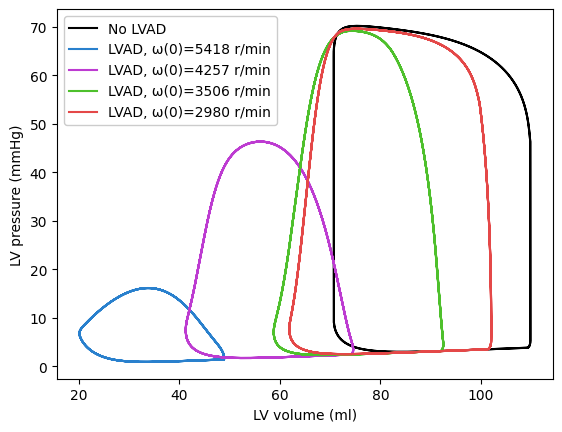

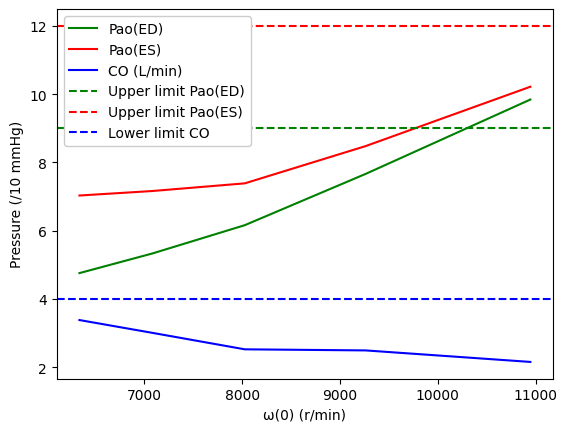

[71.18976805939715, 29.922249299571945, 6.09700390285683, 14.549070352860443, 20.384218881608607]


In [3]:
##patient2:
N = 70
ncycle = 10000
Tc = 0.8
start_v = 70.
Emax = 1.2
Rs = 1.
Rm=0.03
Ra=0.008
Rc = 0.0398
Ca= 0.08
Cs= 1.33
Cr= 4.4
Ls=0.0005
Emin = 0.04
Vd = 14.

gammas = [1.1, 1.3, 1.5, 1.7, 1.9]

vlv_fctns = []
plv_fctns = []
ef_changes = []
pao_eds = []
pao_ess = []
cos = []
maps = []

#get values for periodic loops:
ef_nolvad, pao_ed, pao_es, co_nolvad, y00, y01, y02, y03, y04, Vlv0, Plv0 = f_nolvad(Tc, start_v, Emax, 0)
#pao_eds = [pao_ed]
#pao_ess = [pao_es]

#get suction w: (make w go linearly from w0 to w0 + maxtime * 400, and find w at which suction occurs)
w0 = 5000.
ratew = 400.
x60 = 122.
suctionw = get_suctionw(Tc, start_v, Emax, y00, y01, y02, y03, y04, w0, x60, ratew)

speeds = []
for gamma in gammas: speeds.append(suctionw / gamma)
for gamma in gammas:

  #parameters for lvad:
  c = 0.065 #(in simaan2008dynamical: 0.67, but too fast -> 0.061 gives better shape)
  #with 1.9 also increases CO
  #or between 1.4-2.1 (will make the new pv loop with lvad get closer or further away from the no-lvad pv loop)
  slope0 = 100.
  w0 = suctionw / gamma  #if doesn't work (x6 negative), change gamma down to 1.4 or up to 2.1
  #x60 = 122. #from simaan2008dynamical
  x60 = 0.

  #compute new pv loops and ef with lvad added:
  new_ef, pao_ed, pao_es, CO, MAP, Vlvs, Plvs = f_lvad(Tc, start_v, Emax, c, slope0, w0, x60, y00, y01, y02, y03, y04)
  vlv_fctns.append(Vlvs)
  plv_fctns.append(Plvs)
  pao_eds.append(pao_ed)
  pao_ess.append(pao_es)
  cos.append(CO)
  maps.append(MAP)
  ef_changes.append((new_ef - ef_nolvad) / ef_nolvad * 100.)

  print("\nParameters: Tc, start_v, Emax:", Tc, start_v, Emax)
  print("Suction speed:", suctionw)
  print("EF before LVAD:", ef_nolvad)
  print("CO before LVAD:", co_nolvad)
  print("New EF after LVAD:", new_ef, "New CO:", CO, "New MAP:", MAP, "\n\n")

plt.plot(Vlv0, Plv0, color='black', label='No LVAD') #black
plt.plot(vlv_fctns[0], plv_fctns[0], color=(41/255, 128/255, 205/255), label='LVAD, ω(0)=5418 r/min') #blue
plt.plot(vlv_fctns[1], plv_fctns[1], color=(189/255, 59/255, 209/255), label='LVAD, ω(0)=4257 r/min') #pink
plt.plot(vlv_fctns[2], plv_fctns[2], color=(78/255, 192/255, 44/255), label='LVAD, ω(0)=3506 r/min') #green
plt.plot(vlv_fctns[3], plv_fctns[3], color=(228/255, 72/255, 72/255), label='LVAD, ω(0)=2980 r/min') #red
plt.xlabel('LV volume (ml)')
plt.ylabel('LV pressure (mmHg)')
plt.legend(loc='upper left', framealpha=1)
plt.show()

for i in range(len(pao_eds)):
  pao_eds[i] = pao_eds[i]/10.
  pao_ess[i] = pao_ess[i]/10.
plt.plot(speeds, pao_eds, color='green', label='Pao(ED)')
plt.plot(speeds, pao_ess, color='red', label='Pao(ES)')
plt.plot(speeds, cos, color='blue', label='CO (L/min)')
plt.axhline(y=9, color='green', linestyle='--', label='Upper limit Pao(ED)')
plt.axhline(y=12, color='red', linestyle='--', label='Upper limit Pao(ES)')
plt.axhline(y=4, color='blue', linestyle='--', label='Lower limit CO')
plt.xlabel('ω(0) (r/min)')
plt.ylabel('Pressure (/10 mmHg)')
plt.legend(loc='upper left', framealpha=1)
plt.show()

print(ef_changes)
